# STAT301 Final Project - Group 20

## Introduction
Our global economy drives and depends on functioning companies all around the world, and the characteristics that all organizations have in common are their need and value of their workforce. Employees are one of the most valuable assets and retaining quantity and quality of employees are crucial in running a dependable organization (Negi et. Al, 2013). The failure to do so is called employee attrition, which is a costly challenge faced by many employers around the world. The latter however, is inevitable and managing it is a challenge. Understanding reasons or predictors that could explain employee attrition would provide managers with areas to focus and improve on in the future to improve employee retention (Frye et. Al, 2018). 

## Dataset Description
The dataset chosen: HR Analytics (Konapure & Uikey, 2023) containing 35 different employee factors and characteristics that can be analyzed to understand and interpret organizational data, detecting possible trends and patterns which can be generalized and implemented by companies to assist attrition management. 

**Brief Summary of Entire Dataset**

|Continuous Data|Nominal Data|Ordinal Data|Binary Data|  
|----------------|------------|------------|---------|
|Age           | Employee ID | Frequency of Business Travel | Employee Attrition|
|Daily Wage | Department | Education Level | Over 18|
|Distance to Office | Field of Qualification | Enviromental Satsifcation | Worked Overtime|
|Hourly Rate | Gender | Job Involvement |
|Monthly Income | Marital Status | Job Level |
|Monthly Rate | Job Role | Job Satisfaction 
|Number of Companies Worked | | Performance Rating 
|Percentage Salary Hike | | Relationship Satisfaction 
|Standard Hours | | Stock Option Level 
|Total Working Years| | Work Life Balance
|Training Time |
|Years at Company |
|Years in Current Role |
|Years Since Last Position 
|Years with Current Manager

## Research Question
In our report, we aim to answer the question: **“How can we predict when employees are going to leave?”**

“How can we predict when employees are going to leave? (attrition = 1)” (N)
* Modifying logistic regression to prefer attrition = 1, mention how there’s an imbalance in the response classes
* Discuss how employees departing the company will be a minority (often) of individuals, however we need to design a model using all employee data that can be used to predict the small number of employees that are leaving

“How can we understand what variables are contributing to employee attrition?”
* Using post-lasso to be able to conduct inference
* Idea: splitting data into 3; training-postlasso-test


# Section 2a. Exploratory Data Analysis
To conduct our analysis, we will need to: load the dataset, clean it, and convert it to a tidy format. Below, we load our dataset from the *HR-Employee-Attrition.csv*, convert character columns to factors, and perform a simple check for NA values. Luckily our dataset is already relatively clean from empty values. However, from the dataset description we know that a number of the numeric columns such as `Education` and `JobLevel` represent categorial data. To address this, we will convert all numeric columns with less than 5 distinct values to factors. Finally, we remove superfluous columns such as `Over18`, `EmployeeCount`, `EmployeeNumber`, and `StandardHours` which will not help us predict MonthlyIncome.

In [3]:
suppressMessages(suppressWarnings({
  library(ggplot2)
  library(knitr)
  library(tidyverse)
  library(gridExtra)
  library(kableExtra)
  library(glmnet)
  library(corrplot)
  library(dplyr)
  library(IRdisplay)
  library(webshot)
}))

ERROR: Error in library(kableExtra): there is no package called ‘kableExtra’


## Reading & Cleaning Dataset

In [4]:
# Main developer: Bill
# Contributor: Caden

# Load the data and check for NA values
hr_data <- read.csv("HR-Employee-Attrition.csv", stringsAsFactors = TRUE)
print(paste("Number of NA values:", sum(is.na(hr_data))))

# Convert numeric categorial columns to factors
hr_data <- hr_data |> 
    mutate_if(function(col) {
        is.numeric(col) & n_distinct(col) <= 5 
    }, as.factor)

# Remove unnecessary columns
hr_data <- hr_data |> 
    select(-Over18, -EmployeeCount, -EmployeeNumber, -StandardHours)

# Extract response vector and data matrix
y <- hr_data$Attrition
X <- hr_data |> select(-Attrition)

# Display data preview
head(hr_data)

[1] "Number of NA values: 0"


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<fct>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,⋯,3,1,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,⋯,4,4,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,⋯,3,2,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,⋯,3,3,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,⋯,3,4,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,4,Male,⋯,3,3,0,8,2,2,7,7,3,6


## Exploratory Data Analysis - Distribution of Employee Attrition across HR Dataset

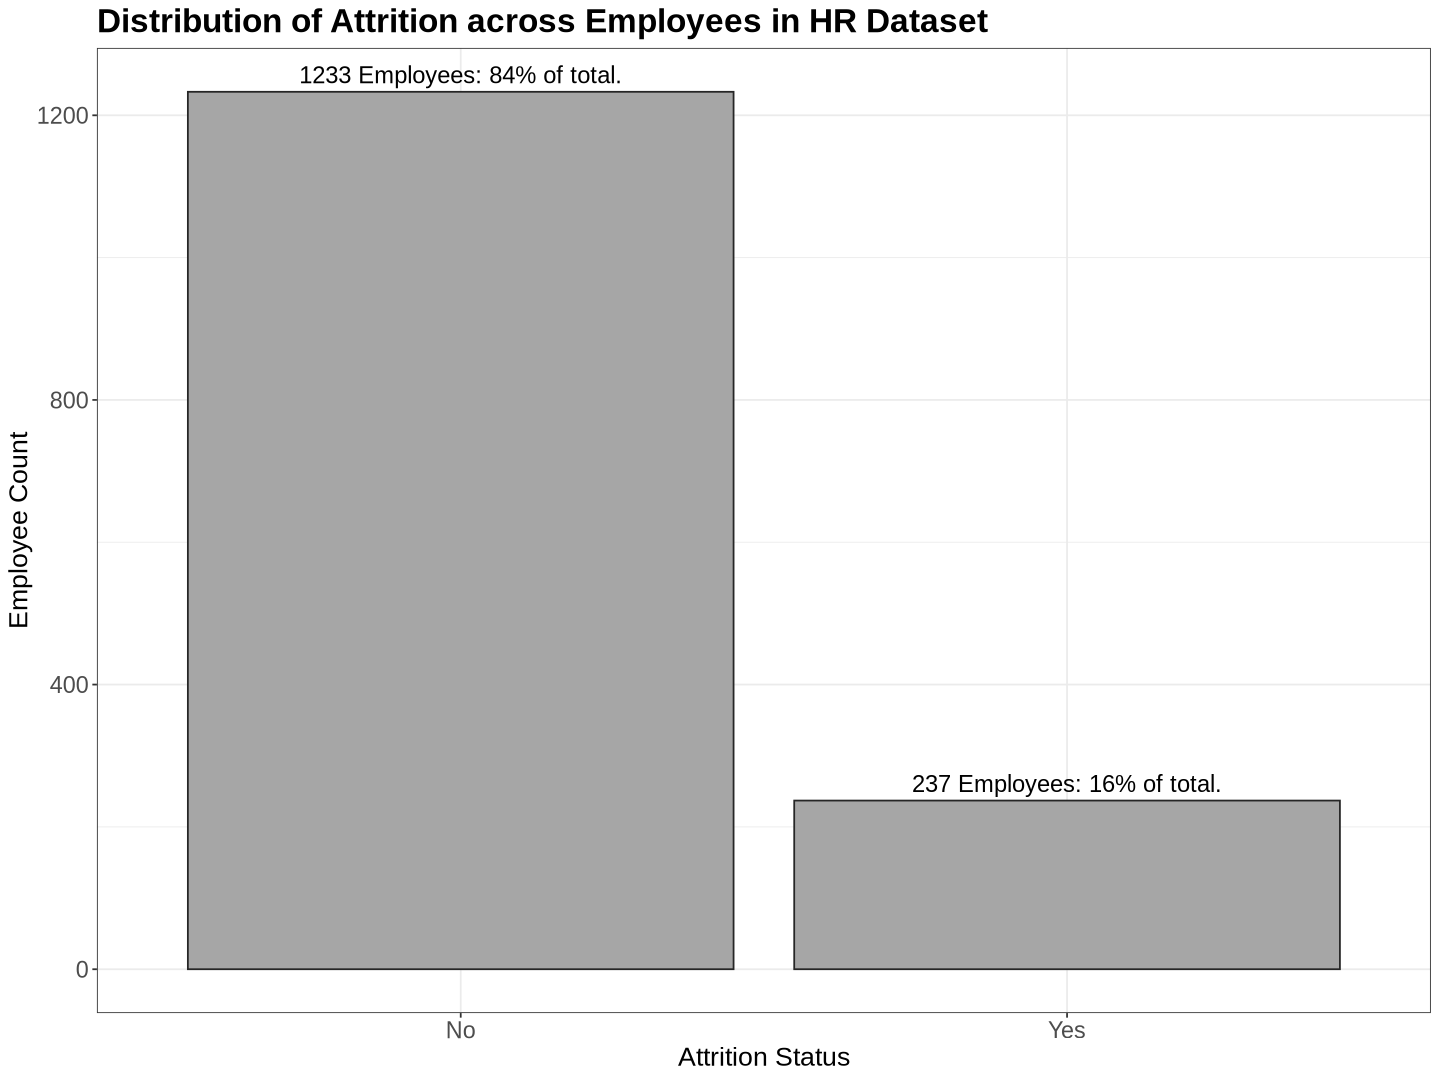

In [6]:
# Main developer: Nusaiba
# Contributor: Caden
options(repr.plot.width = 12, repr.plot.height = 9)
barplot <- hr_data |>
  ggplot() +
  geom_bar(aes(x = Attrition), stat = "count", 
           col = "grey15", fill = "grey65") +
  geom_text(
    stat = "count",
    aes(
      x = Attrition, 
      label = paste0(after_stat(count), " Employees: ",
      100*round(after_stat(count / sum(count)), 2), 
      "% of total.")
    ), 
    vjust = -0.5,
    size = 5
  ) +
  ggtitle("Distribution of Attrition across Employees in HR Dataset") +
  xlab("Attrition Status") +
  ylab("Employee Count") +
  theme_bw() +
  theme(
    plot.title = element_text(color = "Black", size = 20, face = "bold"),
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14)
  )

barplot

We observe that in the dataset:
* 84% of Employees do not have an attritioned status
* Only 16% of Employees in the dataset have attritioned status

**What does this means for us?** This distribution suggests that we should prioritize characteristics and attributes that can predict employee retention, as this sample is larger than the one indicating turnover.

## Correlation Matrix of Variables in Dataset

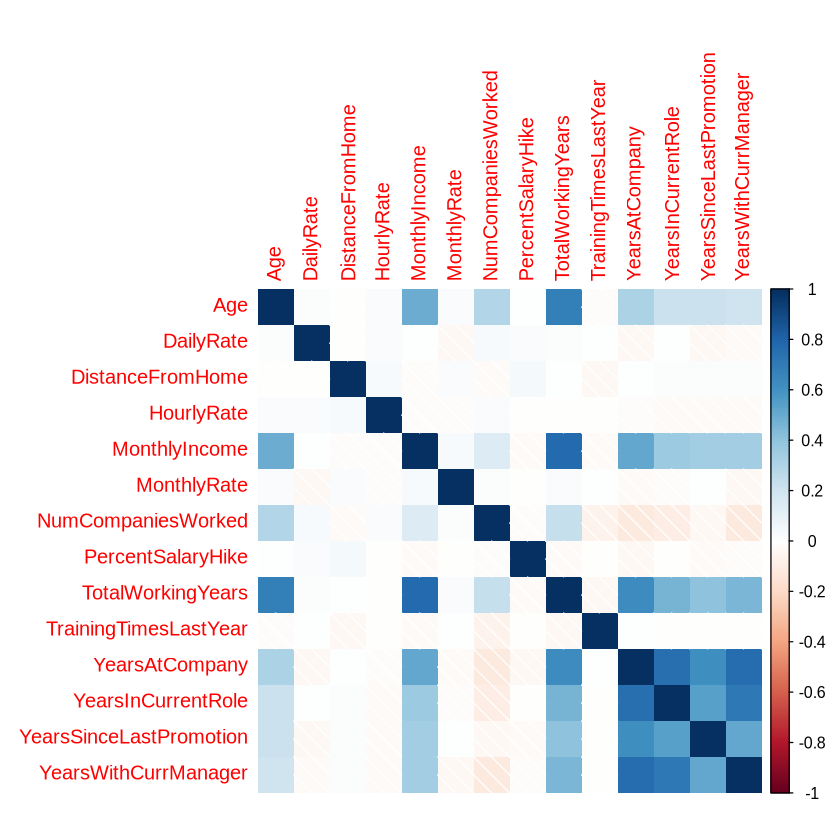

In [6]:
# Main Developer: Kaitlin
# Correlation Matrix to see which factors have impact on each other (highlighting possible confounders present)
cor_matrix <- cor(hr_data[, sapply(hr_data, is.numeric)], use = "complete.obs")
corrplot(cor_matrix, method = "shade") 

### Correlation Matrix Description
Looking closely at MonthlyIncome, we observe: 
* A positive correlation with TotalWorkingYears, YearsAtCompany,Age, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager 

Overall we see that these variables are in relation to each other one way or another, for example, an employee with a higher level of education would have a higher chance in landing a higher job level and recieve a higher paying monthly salary which would likely result in the employee staying in the company. (need to edit)

# Section 2b: Methods and Results

Now we define a new function for assessing the performance of a logistic regression model. Given a Confusion Matrix `conf_in`, it extracts the number of True Positives (`TP`), False Positives (`FP`), True Negatives (`TN`) and False Negatives (`NP`). From these values, we compute Accuracy, Precision, Sensitivity and Specificity and return it as a `list`. In addition, we compute the $F_1$ and $F_{\beta}$ scores by the following:
$$
F_{\beta} = \frac{(1 + \beta^2) \cdot \text{TP}} {(1 + \beta^2) \cdot \text{TP} + \beta^2 \cdot \text{FN} + \text{FP}} \hspace{0.75cm} \overset{\beta = 1}{\longrightarrow} \hspace{0.75cm} F_{1} = \frac{2 \text{TP}} {2 \text{TP} + \text{FN} + \text{FP}} 
$$

In [7]:
# Main developer: Caden
# compute the performance metrics given a conf. matrix
compute_metrics <- function(conf_in, beta = 2){
  # extract table info
  TP <- conf_in[2, 2]
  FP <- conf_in[2, 1]
  TN <- conf_in[1, 1]
  FN <- conf_in[1, 2]
  # compute metrics
  accuracy <- (TP + TN) / sum(conf_in)
  precision <- TP / (TP + FP)
  sensitivity <- TP / (TP + FN)
  specificity <- TN / (TN + FP)
  # compute F1 score
  F1 <-  2*TP / (2*TP + FP + FN)
  # compute F-beta score. Defaults to F2
  FB <- (1 + beta^2) * TP / ((1 + beta^2) * TP + beta^2 * FN + FP)
  # return everything
  return(list(
    ACC = accuracy,
    PRE = precision,
    SEN = sensitivity,
    SPC = specificity,
    F1  = F1,
    FB  = FB
  ))
}

Now, we fix the seed and designate a training set and an inference set. We will use a $60-40$ split. We also define the `model.matrix` to get our covariates ready for input into `glmnet`. 

In [8]:
# Main developer: Caden
# Contributor: Bill
set.seed(42)
# rename to match my conventions
df <- hr_data
# train-test split: 60-40
train_indices <- sample(1:nrow(df), size = 0.60 * nrow(df), replace = FALSE)
train <- df[train_indices, ]
# get unselected indices
inference  <- df[-train_indices, ]
# prepare data for glmnet
x <- model.matrix(Attrition ~ . - 1, data = train)
y <- as.numeric(train$Attrition == "Yes")
# write train and inference response as boolean
train$Attrition <- as.numeric(train$Attrition == "Yes")
inference$Attrition <- as.numeric(inference$Attrition == "Yes")

Then, for weights $w \in [1,10]$ we apply a weight of $w$ to the set of $\{y \in \mathbf{\vec{y}} \mid y = 1\}$ to follow the procedure described in the Methods section. Then, for each weight, we construct a model $\mathcal{M}_w$ by selecting the variables using Lasso Constraints and cross-validation. Then, we compute and record the in-sample metrics and store the model information in the `models_list`. 

In [9]:
# Main developer: Caden
# define weights and lists
weights_list <- 1:10
models_list <- list()
results_rw <- list()
perf_list <- list()
# iterate across weights results
for(w in weights_list){
  
  # increase weight of employee leaving by `w`
  weights <- ifelse(y == 1, w, 1)
  
  # ----------------------- #
  # --- Logistic LASSO ---- #
  # ----------------------- #
  # CV Lasso Logistic
  cv_logistic <- cv.glmnet(
    x, y,
    # using LASSO 
    alpha = 1,
    # weights in this iteration
    weights = weights,
    # logistic regression
    family = "binomial",
    # 15-fold CV
    nfolds = 15
  )
  # in-sample predictions
  yhat_lasso <- as.numeric(predict(
    cv_logistic,
    newx = x,
    s = "lambda.min",
    type = "response"
  ) > 0.5)
  # compute confusion matrix metrics
  mat_ins_w <- compute_metrics(table(yhat_lasso, y), beta = 2)
  
  # ----------------------- #
  # --- Selected Vars. ---- #
  # ----------------------- #
  # then extract chosen variables
  coefs_min <- coef(cv_logistic, s = "lambda.min")
  s_min <- rownames(coefs_min)[which(coefs_min != 0)]
  s_min <- s_min[s_min != "(Intercept)"]
  # match training columns to the original columns
  matched_columns <- unique(sapply(s_min, function(var) {
    # match selected columns+factor levels to
    matches <- colnames(df)[which(sapply(colnames(df), function(orig)
      grepl(orig, var)))]
    if (length(matches) > 0) {
      # get longest match name (e.g. EducationField vs. Education)
      matches[which.max(nchar(matches))]
    }
  }))
  # store chosen variables
  models_list[[w]] <- matched_columns

  # ---------------------- #
  # --- Perf. Metrics ---- #
  # ---------------------- #
  # report metrics
  results_rw[[w]] <- data.frame(train = round(
    c(
      ACC  = mat_ins_w$ACC,
      PRE  = mat_ins_w$PRE,
      SEN  = mat_ins_w$SEN,
      SPC  = mat_ins_w$SPC,
      # also extract the F1 score
      F1  = mat_ins_w$F1,   
      # and the F2 (beta = 2) score
      FB  = mat_ins_w$FB,
      # estimated difference in accuracy-sensitivity
      DLT  = abs(mat_ins_w$ACC - mat_ins_w$SEN),
      # estimated difference in accuracy-sensitivity
      AVG  = mean(mat_ins_w$ACC, mat_ins_w$SEN),
      # also report Mean Cross-Validated Error at Lambda Min
      CVM  = cv_logistic$cvm[which(cv_logistic$lambda == cv_logistic$lambda.min)],
      # and the Estimate of Standard Error of CVM
      CVSE = cv_logistic$cvsd[which(cv_logistic$lambda == cv_logistic$lambda.min)]
    ),
    3
  ))
}

Then, we clean the results of the algorithm and compute $w^{\star}$ as $\text{argmin}_{w \in [1, \omega]}(\mathcal{P}_w)$.

In [10]:
# Main developer: Caden
# --------------------- #
# --- Clean Output ---- #
# --------------------- #
results_clean <- do.call(cbind, results_rw)
colnames(results_clean) <- paste0("w=", weights_list)
# which has the highest F1 score
best_w_f1 <- which.max(results_clean["F1", ])
# which has the highest FB score
best_w_fb <- which.max(results_clean["FB", ])
cat(paste0("The weight corresponding to the best training-set LASSO under the F1 statistic is w=",  best_w_f1, ".\n"))
cat(paste0("The weight corresponding to the best training-set LASSO under the FB statistic is w=", best_w_fb, "."))

The weight corresponding to the best training-set LASSO under the F1 statistic is w=2.
The weight corresponding to the best training-set LASSO under the FB statistic is w=6.

Now to help regulate the bias of LASSO we fit a Logistic Model using `glm` and the held-out set.  We fit a post-LASSO $w = 1$ (the "Baseline" or "Unweighted") model and a $w = w^{\star}$ ("Weighted") model. We use the covariates saved in `models_list` from the main training loop for each model, implying that different covariates could be selected for the different models. 

In [11]:
# Main developer: Caden
# ------------------- #
# --- Post-LASSO --- #
# ------------------- #
# get the columns of best f1 weight and append response
post_lasso_df <- inference[, c("Attrition", models_list[[best_w_f1]])]
# compute weights according to best result
weights_f1 <- ifelse(post_lasso_df$Attrition == 1, best_w_f1, 1)
# use regular glm to train post-lasso model
mod_post_lasso <- glm(Attrition ~ ., weights = weights_f1,
                      data = post_lasso_df,family = "binomial")

# repeat for fb weight
post_lasso_df_b <- inference[, c("Attrition", models_list[[best_w_fb]])]
# compute weights according to best result
weights_fb <- ifelse(post_lasso_df$Attrition == 1, best_w_fb, 1)
# use regular glm to train post-lasso model
fb_post_lasso <- glm(Attrition ~ ., weights = weights_fb,
                      data = post_lasso_df, family = "binomial")

# ------------------ #
# ---- Baseline ---- #
# ------------------ #
# get the columns of the unweighted model from LASSO
baseline_df <- inference[, c("Attrition", models_list[[1]])]
# use regular glm to train baseline post-lasso model
baseline_post_lasso <- glm(Attrition ~ .,
                           data = baseline_df,
                           family = "binomial")
# -------------------- #
# -- Inference Set -- #
# ------------------- #
# baseline post-LASSO fitted values
base_preds <- predict(baseline_post_lasso, newdata = inference, type = "response") > 0.50
# weighted post-LASSO fitted values
post_preds_f1 <- predict(mod_post_lasso, newdata = inference, type = "response") > 0.50
post_preds_fb <- predict(fb_post_lasso, newdata = inference, type = "response") > 0.50
# compute confusion matrix for baseline
perf_PB <- compute_metrics(table(base_preds, inference$Attrition))
# and for F1/FB models
perf_PFB <- compute_metrics(table(post_preds_fb, inference$Attrition))
perf_PF1 <- compute_metrics(table(post_preds_f1, inference$Attrition))

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Further, we compute the out-of-sample performance for both post-LASSO `glm` fits, so we can assess whether the weighted model is predicting $\text{Attrition} = 1$ better than the baseline model. In addition, we extract the training performance from the original LASSO fitting process for each model. We thus have three

In [52]:
# Main developer: Caden
# ------------------- #
# -- Clean Results -- #
# ------------------- #

# get the training performance for both weighted and unweighted
lasso_FB <- t(results_rw[[best_w_fb]])[1:6]
lasso_L <- t(results_rw[[best_w_f1]])[1:6]
lasso_B <- t(results_rw[[1]])[1:6]
# summarize results
results = data.frame(
  lasso_WTB = lasso_FB,
  post_WTB  = round(unlist(perf_PFB), 3),
  lasso_WT1 = lasso_L,
  post_WT1  = round(unlist(perf_PF1), 3),
  lasso_UW  = lasso_B,
  post_UW   = round(unlist(perf_PB), 3)
)
# set column names (will become row names)
colnames(results) <- rep(c("Lasso", "Post-Lasso"), times = 3)
# transpose the results matrix so it makes more sense when presented
results <- t(results)
# add the column selection metrics
# select column names of both without "Attrition"
S_fb <- models_list[[best_w_fb]]
S_BL <- models_list[[1]]
S_f1 <- models_list[[best_w_f1]]
# append the number of selected variables for each model
results <- cbind(results, K = c(length(S_fb), "",
                                length(S_f1), "", 
                                length(S_BL), ""))
# --------------------- #
# -- Construct Table -- #
# --------------------- #
results_table <- kable(
  results, 
  col.names = c(
    "Accuracy", "Precision",
    "Sensitivity", "Specificity",
    "F<sub>1</sub> Score", "F<sub>β</sub> Score",
    "Variables Selected"
  ),
  caption = "Table 1: Summary of Performance Metrics Across Models",
  escape = FALSE,  
  format = "html"  
) %>%
  # manually add html alignment/styling to titles so it renders in Jupyter nicely
  pack_rows('<div style="text-align: left;">F<sub>β</sub> Score Preferred Model</div>', 1, 2, escape = FALSE) %>%
  pack_rows('<div style="text-align: left;">F<sub>1</sub> Score Preferred Model</div>', 3, 4, escape = FALSE) %>%
  pack_rows('<div style="text-align: left;">Unweighted Model</div>', 5, 6, escape = FALSE) %>%
  kable_styling(
    font_size = 12
  ) %>% 
  column_spec(1:7, width = "2.5cm")

results_table %>%
  as.character() %>%
  display_html()


Table 1: Summary of Performance Metrics Across Models 
 
 
 
 Accuracy 
 Precision 
 Sensitivity 
 Specificity 
 F 1 Score 
 F β Score 
 Variables Selected 
 
 
 
 F β Score Preferred Model 
 
 Lasso 
 0.805 
 0.44 
 0.863 
 0.794 
 0.583 
 0.724 
 29 
 
 
 Post-Lasso 
 0.825 
 0.486 
 0.908 
 0.808 
 0.633 
 0.774 
 
 
 F 1 Score Preferred Model 
 
 Lasso 
 0.9 
 0.689 
 0.669 
 0.943 
 0.679 
 0.673 
 28 
 
 
 Post-Lasso 
 0.895 
 0.67 
 0.724 
 0.929 
 0.696 
 0.713 
 
 
 Unweighted Model 
 
 Lasso 
 0.904 
 0.846 
 0.475 
 0.984 
 0.608 
 0.521 
 28 
 
 
 Post-Lasso 
 0.912 
 0.811 
 0.612 
 0.971 
 0.698 
 0.644

**Interpretation of Table 1 (outline)**
  - The $F_{\beta}$ model (which weighs $\text{Attrition} = 1$ at $w = 6$) has high sensitivity both in-sample and in the inference set.  The sensitivity, i.e. proportion of true positives detected, relative to the total number of actual positives, is around $30\%$ higher than the baseline model and $17\%$ higher than the $F_1$ model. This comes at a cost of about $10\%$ overall accuracy relative to both.
  - To contrast, the $F_1$ model (which weighs $\text{Attrition} = 1$ at $w = 2$) strikes a balance between the $F_{\beta}$ and unweighted models. It has an increase in sensitivity of about $10\%$ relative to the baseline at no substantial cost (appx. $1\%$) to the accuracy and with slight cost to the precision.
  - Finally, the unweighted model has the best overall accuracy, which is reflected in higher precision and specificity. However, it is only detecting true positives around $47.5\%$ of the time (relative to the true number of positives) in the training data and around $60\%$ in the test data.

**Some thoughts**
- If our goal was prediction, we could potentially prefer the $F_1$ model. It is likely to have better test set performance. This is because it seems to be expressing a balance of all metrics (precision/sensitivity/$F_1$/accuracy/etc.) compared to the other two models. If we had a representative test set it would likely (though not guaranteed until we test) have fewer false negatives than the baseline and fewer false positives than the $F_{\beta}$. Though it may not have the best overall accuracy.
- Since our goal is to study the effects of attaching more value to $\text{Attrition} = 1$ relative to $\text{Attrition} = 0$ on the coefficient estimates, we will investigate further the differences between the $F_{\beta}$ model and the unweighted model. By construction, the $F_{\beta}$ score is under the assumption that  "the user who attaches $\beta$ times as much importance to [sensitivity] as precision" (src: https://www.dcs.gla.ac.uk/Keith/Preface.html,  Van Rijsbergen, C. J. (1979). Information Retrieval (2nd ed.). Butterworth-Heinemann.) In our case, the model was selected under the assumption we attach $\beta = 2$ times as much importance to Attrition = "Yes" (1) to "No" (0).
- To contrast, both the unweighted and $F_1$ models are treating them with *equal* importance. Despite the fact that $F_1$ selected $w = 2$ this is simply the weighing of Attrition = 1 that maximized the harmonic mean of precision and sensitivity (src: https://bmcmedimaging.biomedcentral.com/articles/10.1186/s12880-015-0068-x  Aziz Taha, Abdel (2015). BMC Medical Imaging. 15 (29): 1–28) for the integer weights provided in the test set.


We now extract the $p$-values for the coefficients for both models and convert them to log scale. On each plot, we include vertical lines corresponding to the logarithm of $\alpha \in \{0.01, 0.05, 0.10\}$. For visual simplicity, we plot the numeric covariates on one plot and the categorical coefficients on another. The horizontal lines dictates the distance in log_

In [16]:
# Main developer: Caden
options(repr.plot.width = 22, repr.plot.height = 9)

# --------------------- #
# -- Combine Results -- #
# --------------------- #
# get coefficients from both post-LASSO models
coef_table <- as.data.frame(summary(fb_post_lasso)$coefficients) %>% mutate(Coefficient = rownames(.))
coef_baseline <- as.data.frame(summary(baseline_post_lasso)$coefficients) %>% mutate(Coefficient = rownames(.))
# join them togeth by coefficients
joined_coefs <- full_join(coef_table, coef_baseline, by = "Coefficient")
# set p-value of NA coefficients to 1.0 (assuming not selected implies p = 1)
joined_coefs$`Pr(>|z|).y`[which(is.na( joined_coefs$`Pr(>|z|).y`))] <- 1
joined_coefs$`Pr(>|z|).x`[which(is.na( joined_coefs$`Pr(>|z|).x`))] <- 1
# extract p-values for coefficients of weighted and unweighted models
plotDF <- data.frame(Weighted = (joined_coefs$`Pr(>|z|).x`), 
                     Baseline = (joined_coefs$`Pr(>|z|).y`))
# add the coefficient names as a column
plotDF$variable <- joined_coefs$Coefficient
# get names of numeric columns from original data frame
numeric_cols <- colnames(X %>% select_if(is.numeric))

# ----------------------- #
# -- Numeric Coef Plot -- #
# ----------------------- #
# for the first plot, we do the p-values of numeric columns
plotDF_N <- plotDF[plotDF$variable %in% numeric_cols, ]
# we pivot the data to prepare it for plotting
plotDF_long <- plotDF_N %>%
  pivot_longer(cols = c(Weighted, Baseline), 
               names_to = "Model", 
               values_to = "pval")

# create the plot of numeric coefficient p-values
pN <- ggplot(plotDF_long, aes(x = pval, y = variable, color = Model)) +
  # add the line first so that its not on top of the points
  geom_line(aes(group = variable),
            color = "grey30",
            linewidth = 0.5) +
  # add points for p-values
  geom_point(size = 2) +
  # convert to log-scale for readability
  scale_x_log10() +
  labs(x = "P-value (log scale)", y = "Numeric Variable", color = "Model") +
  scale_color_manual(values = c(
    "Weighted" = "#004346",
    "Baseline" = "#508991"
  )) +
  geom_vline(xintercept = 0.01,
             linetype = "dashed",
             color = "#75dddd") +
  geom_vline(xintercept = 0.05,
             linetype = "dashed",
             color = "#09bc8a") +
  geom_vline(xintercept = 0.10,
             linetype = "dashed",
             color = "#004346") +
  labs(title = "Log P-Values for Numeric Variables, Post-LASSO Weighted vs Unweighted", 
       subtitle = "Vertical Lines are Significance {0.01, 0.05, 0.10} Respectively") +
  theme_bw() +
  theme(
    axis.text.y = element_text(size = 12),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    plot.title = element_text(size = 15),
    plot.subtitle = element_text(size = 12),
    legend.text = element_text(size = 10),
    legend.title = element_text(size = 12)
  ) 

For the second plot contanining categorical variables, there are many more $p$-values to be plotted than in the numeric model. This is due to the fact that there is a coefficient/dummy variable for each factor level beyond the baseline. Hence, we filter out those coefficients where both of the observed $p$-values are above the $10\%$ significance level.

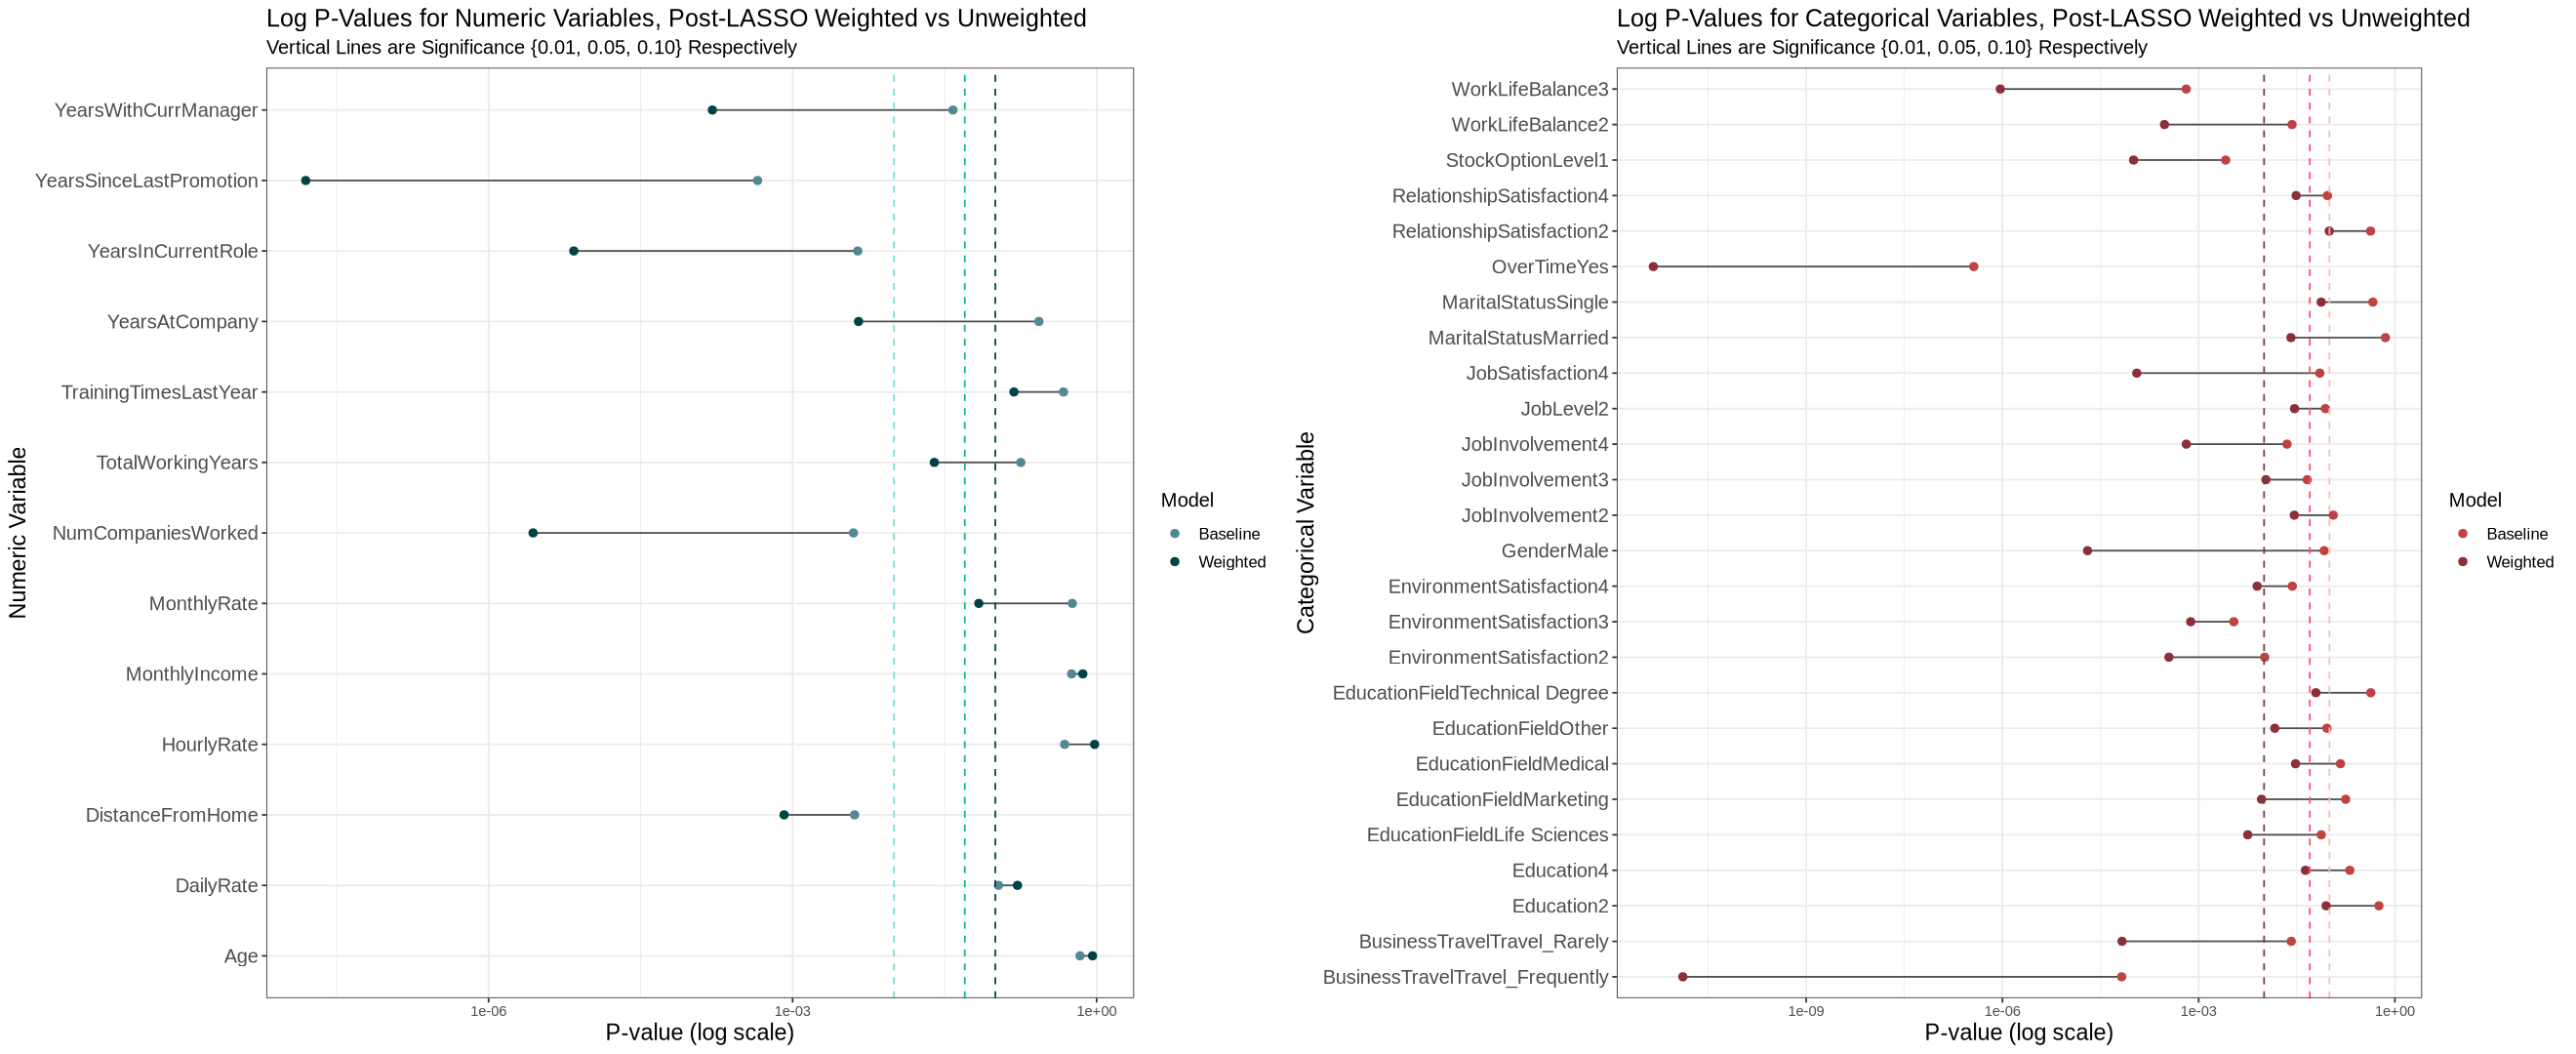

In [17]:
# Main developer: Caden
# ------------------- #
# -- Category Coef -- #
# ------------------- #
# for the second plot, we do the p-values of categorical columns
plotDF_C <- plotDF[!plotDF$variable %in% numeric_cols, ]
# however there are many more than numeric
# so we select only those with at least one significant at 0.10
plotDF_C <- plotDF_C[plotDF_C$Weighted < 0.10 | plotDF_C$Baseline < 0.10, ]
# we pivot the data to prepare it for plotting
plotDF_longC <- plotDF_C %>%
  pivot_longer(cols = c(Weighted, Baseline), 
               names_to = "Model", 
               values_to = "pval")

# create the plot of numeric coefficient p-values
pC <- ggplot(plotDF_longC, aes(x = pval, y = variable, color = Model)) +
  # add the line first so that its not on top of the points
  geom_line(aes(group = variable),
            color = "grey30",
            linewidth = 0.5) +
  # add points for p-values
  geom_point(size = 2) +
  # convert to log-scale for readability
  scale_x_log10() +
  labs(x = "P-value (log scale)", y = "Categorical Variable", color = "Model") +
  scale_color_manual(values = c(
    "Weighted" = "#8c2f39",
    "Baseline" = "#bf4342"
  )) +
  geom_vline(xintercept = 0.01,
             linetype = "dashed",
             color = "#723d46") +
  geom_vline(xintercept = 0.05,
             linetype = "dashed",
             color = "#ff4d6d") +
  geom_vline(xintercept = 0.10,
             linetype = "dashed",
             color = "#fcb9b2") +
  labs(title = "Log P-Values for Categorical Variables, Post-LASSO Weighted vs Unweighted", 
       subtitle = "Vertical Lines are Significance {0.01, 0.05, 0.10} Respectively") +
  theme_bw() +
  theme(
    axis.text.y = element_text(size = 12),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    plot.title = element_text(size = 15),
    plot.subtitle = element_text(size = 12),
    legend.text = element_text(size = 10),
    legend.title = element_text(size = 12)
  ) 
grid.arrange(pN, pC, ncol = 2)

**Interpretation of Figure 2 (outline)**
  - Both models selected basically the same variables. The weighted model selected Age when the unweighted did not; however, the coefficient for age was not statistically significant
  - Under the $F_{\beta}$ model, the log $p$-values tend to decrease, indicating a general increase in significance for the selected variables when attrition=yes is prioritized.
  - The magnitude of the change in $p$-values is indicated by the horizontal lines.
  - A few variables of note were not significant in the unweighted model, and became statistically significant in the weighted model. These include...
    - **Most interesting**: Crossing two or more vertical lines.
    - *These are some examples*: pick any that are worth talking about. Look for horizontal lines crossing two or more vertical lines.
    - `YearsAtCompany`: Not significant at any testing level (i.e. $p > 0.10$) in the unweighted model. Significant at $\alpha = 0.01$ (i.e. $p < 0.01$ for the weighted model.)
    - `TotalWorkingYears`: Not significant at $\alpha = 0.10$ in the unweighted model. Significant at $\alpha = 0.05$ (i.e. $p < 0.05$ for the weighted model.)
    - `GenderMale`: Not significant at $\alpha = 0.05$ (i.e. $p > 0.05$)  in the unweighted model. Significant at $\alpha = 0.05$ (i.e. $p < 0.05$ for the weighted model.)
    - `MaritalStatusMarried`: Not significant any testing level (i.e. $p > 0.10$) in the unweighted model. Significant at $\alpha = 0.01$ (i.e. $p < 0.01$ for the weighted model.)
    - `EducationField` (many different factor levels): Most were insignificant at $\alpha = 0.05$ in the unweighted model and significant at $\alpha = 0.05$ or even $\alpha = 0.01$ in the weighted model.

General comments: Those variables that were significant in the unweighted model generally remained significant (with $p$ decreasing) in the weighted model.
The variables selected all seem to have an impact on attrition=1. Those that shifted the most likely have an even larger impact on attrition=1. Discuss these in context?